Для переобучения выбрал 2 стратегии:
1. Модель должна быть достаточно сложна для описания данных, чтобы суметь "запомнить" весь датасет - добавил 2 доп слоя с relu
2. Существенно ограничил количество данных, чтобы были заметны отличия train от valid - train 5000 примеров, valid 1000

В итоге на графиках (особенно лосса) заметно, что примерно после 15 эпохи сеть начинает потихоньку переобучаться, теряя качество предсказаний на valid

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, fashion_mnist, plot_graphs
import numpy as np

In [2]:
train_loader, valid_loader, test_loader = fashion_mnist(valid=1000)

In [3]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_odd1 = nn.Linear(128, 64)
        self.fc_odd2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.tanh(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = torch.tanh(self.fc2(x))
        x = F.relu(self.fc_odd1(x))
        x = F.relu(self.fc_odd2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [4]:
?torch.relu

In [5]:
def train(epoch, models):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for k, model in models.items():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        print(line + losses)

In [6]:
# models = {'default': Net(False, False), 'bn': Net(True, False), 'drop': Net(False, True), 'both': Net(True, True)}
models = {'bn': Net(True, False)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            # output = {k: m(data) for m in models}
            for k, m in models.items():
                output = m(data)
                test_loss[k] += m.loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: 100. * correct[k] / test_size for k in correct}
    lines = '\n'.join([line(k, test_loss[k], correct[k], correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)
    test(models, train_loader, train_log)

Train Epoch: 1 [0/5000 (0%)]	Losses bn: 2.307938
Train Epoch: 1 [5000/5000 (100%)]	Losses bn: 1.996004
Test set:
bn: Loss: 2.0059	Accuracy: 676.0/1000 (68%)

Test set:
bn: Loss: 1.9978	Accuracy: 3512.0/5000 (70%)

Train Epoch: 2 [0/5000 (0%)]	Losses bn: 2.023337
Train Epoch: 2 [5000/5000 (100%)]	Losses bn: 1.496465
Test set:
bn: Loss: 1.4804	Accuracy: 683.0/1000 (68%)

Test set:
bn: Loss: 1.4576	Accuracy: 3556.0/5000 (71%)

Train Epoch: 3 [0/5000 (0%)]	Losses bn: 1.454855
Train Epoch: 3 [5000/5000 (100%)]	Losses bn: 1.027962
Test set:
bn: Loss: 0.9774	Accuracy: 749.0/1000 (75%)

Test set:
bn: Loss: 0.9523	Accuracy: 3824.0/5000 (76%)

Train Epoch: 4 [0/5000 (0%)]	Losses bn: 1.002462
Train Epoch: 4 [5000/5000 (100%)]	Losses bn: 0.562984
Test set:
bn: Loss: 0.7584	Accuracy: 760.0/1000 (76%)

Test set:
bn: Loss: 0.7120	Accuracy: 3917.0/5000 (78%)

Train Epoch: 5 [0/5000 (0%)]	Losses bn: 0.994412
Train Epoch: 5 [5000/5000 (100%)]	Losses bn: 0.704290
Test set:
bn: Loss: 0.6469	Accuracy: 773.

Train Epoch: 39 [0/5000 (0%)]	Losses bn: 0.261148
Train Epoch: 39 [5000/5000 (100%)]	Losses bn: 0.266947
Test set:
bn: Loss: 0.5305	Accuracy: 825.0/1000 (82%)

Test set:
bn: Loss: 0.1727	Accuracy: 4733.0/5000 (95%)

Train Epoch: 40 [0/5000 (0%)]	Losses bn: 0.227844
Train Epoch: 40 [5000/5000 (100%)]	Losses bn: 0.175160
Test set:
bn: Loss: 0.5356	Accuracy: 828.0/1000 (83%)

Test set:
bn: Loss: 0.1728	Accuracy: 4718.0/5000 (94%)

Train Epoch: 41 [0/5000 (0%)]	Losses bn: 0.144036
Train Epoch: 41 [5000/5000 (100%)]	Losses bn: 0.158011
Test set:
bn: Loss: 0.5616	Accuracy: 825.0/1000 (82%)

Test set:
bn: Loss: 0.1828	Accuracy: 4675.0/5000 (94%)

Train Epoch: 42 [0/5000 (0%)]	Losses bn: 0.179493
Train Epoch: 42 [5000/5000 (100%)]	Losses bn: 0.109832
Test set:
bn: Loss: 0.5980	Accuracy: 809.0/1000 (81%)

Test set:
bn: Loss: 0.1969	Accuracy: 4668.0/5000 (93%)

Train Epoch: 43 [0/5000 (0%)]	Losses bn: 0.149722
Train Epoch: 43 [5000/5000 (100%)]	Losses bn: 0.173187
Test set:
bn: Loss: 0.5533	Accu


Train Epoch: 77 [0/5000 (0%)]	Losses bn: 0.220910
Train Epoch: 77 [5000/5000 (100%)]	Losses bn: 0.167059
Test set:
bn: Loss: 0.7102	Accuracy: 823.0/1000 (82%)

Test set:
bn: Loss: 0.0681	Accuracy: 4911.0/5000 (98%)

Train Epoch: 78 [0/5000 (0%)]	Losses bn: 0.049063
Train Epoch: 78 [5000/5000 (100%)]	Losses bn: 0.158692
Test set:
bn: Loss: 0.7904	Accuracy: 813.0/1000 (81%)

Test set:
bn: Loss: 0.1271	Accuracy: 4742.0/5000 (95%)

Train Epoch: 79 [0/5000 (0%)]	Losses bn: 0.046631
Train Epoch: 79 [5000/5000 (100%)]	Losses bn: 0.182290
Test set:
bn: Loss: 0.7711	Accuracy: 815.0/1000 (82%)

Test set:
bn: Loss: 0.1178	Accuracy: 4794.0/5000 (96%)

Train Epoch: 80 [0/5000 (0%)]	Losses bn: 0.124918
Train Epoch: 80 [5000/5000 (100%)]	Losses bn: 0.320766
Test set:
bn: Loss: 0.7381	Accuracy: 819.0/1000 (82%)

Test set:
bn: Loss: 0.0815	Accuracy: 4864.0/5000 (97%)

Train Epoch: 81 [0/5000 (0%)]	Losses bn: 0.060585
Train Epoch: 81 [5000/5000 (100%)]	Losses bn: 0.094158
Test set:
bn: Loss: 0.7353	Acc

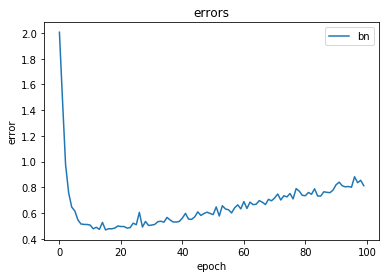

In [9]:
plot_graphs(test_log, 'loss')

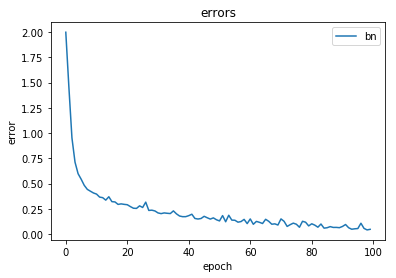

In [12]:
plot_graphs(train_log, 'loss')

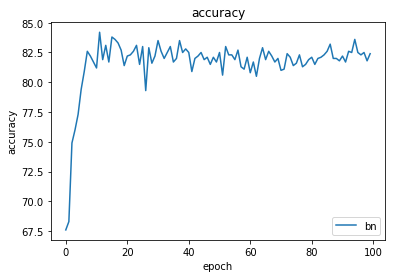

In [10]:
plot_graphs(test_log, 'accuracy')

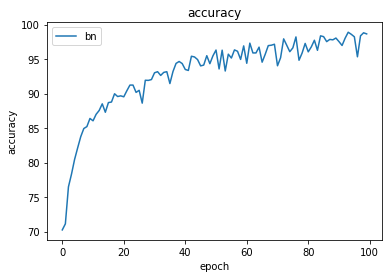

In [11]:
plot_graphs(train_log, 'accuracy')